In [3]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
path = r'companies' # use your path
all_files = os.listdir(path)

############################
def return_min_length(data):
    min_len = float('inf')
    for key in data:
        if len(data[key]) < min_len:
            min_len = len(data[key])
    return min_len
########################
def get_data(filename):
    #Getting latest date from previous dataset
    data = pd.read_csv('./companies/'+filename) # Read Data set
    data['date'] = pd.to_datetime(data.date) #Convert date index to proper format
    data.set_index('date', inplace=True) #Set date column as index
    close = data['close'] # Get close price from data set
    close = close.replace(',','', regex=True).astype(float)
    return close
########################
def get_portfolio_dataframe(companies_list):
    try:
        all_close_prices = dict()
        for filename in companies_list:
            df = get_data(filename) # Read given file name into data frame
            
#             column_name = filename.split("KSE-30 All Companies")[-1].split('.')[0] # Get TICKER SYMBOL of company from filename
            
            all_close_prices[filename] = df.values # Add to dictionary 
        
        min_len = return_min_length(all_close_prices) # Get minimum length of from all the data

        for key in all_close_prices:
            
            # Set data of all companies to minimum length
            all_close_prices[key] = all_close_prices[key][:min_len] 

        final_df = pd.DataFrame(all_close_prices) # Make DF from dictionary
        
        df = df[:min_len]  # Set latest data frame to minimum length
        
        final_df.index = df.index # Set index of latest read data frame to final data frame
        
        final_df = final_df.sort_index() #Sort from oldest to latest 
        final_df.columns = [x.replace('.csv','') for x in final_df.columns]
        return final_df # Return final dataframe

    except Exception as e:
        print("Exception in getting portfolio dataframe: ",e)

########################
## RETURNS PERCENTAGE CHANGE OF EACH COMPANY WITH THE PASSAGE OF TIME (IN THIS CASE 1 DAY)
def percentage_change(df):
    return df.pct_change().apply(lambda x: np.log(1+x))

########################
## INDIVIDUAL EXPECTED RETURN OF EACH COMPANY BASED ON TIME PERIOD
def individual_exprected_returns(df,time_period_occurance):
    time_periods = ["Y","M","W","D"]
    if time_period_occurance in time_periods:
        # Yearly,Monthly,Weekly and Daily returns for individual companies
        return df.resample(time_period_occurance).last().pct_change().mean()
    else:
        return

########################
# Function to get volatility and expected returns for each stock based upon time period
def returns_volatility_portfolio(df,time_period,time_period_occurance):
    # Volatility is given by the annual standard deviation. 
    # Annual Standard Deviation of each company in portfolio
    annual_std = percentage_change(df).std().apply(lambda x: x*np.sqrt(time_period))
    
    ind_expectedRetruns = individual_exprected_returns(df,time_period_occurance)
    
    assets = pd.concat([annual_std,ind_expectedRetruns], axis=1) 
    assets.columns = ["Volatility","Returns"]
    ind = [x.strip('.csv') for x in assets.index]
    assets['Returns_Percentage'] = round(individual_exprected_returns(df,time_period_occurance)*100,2)
    return assets

########################
## Total portfolio return
def total_portfolio_returns(df,time_period,weights,time_period_occurance):    
    
    ind_expectedRetruns = individual_exprected_returns(df,time_period_occurance) # get individual returns  
    
    result = (weights*ind_expectedRetruns).sum() # Multiply with individual weight and sum 
    
    return round(result,3)

########################
## Portfolio Variance
def total_portfolio_variance(df,time_period,weights):
    covariance = portfolio_covariance(df) # Covariance between all assets of portfolio
    covariance = covariance * time_period # Results with in given time period
    result1 = np.dot(covariance , weights)
    variance = round(np.dot(np.array(weights).T,result1),2) 
    return variance

########################
## Portfolio Volatility
def total_portfolio_volatility(df,time_period,weights):
    portfolio_variance = total_portfolio_variance(df,time_period,weights)
    volatility = np.sqrt(portfolio_variance)
    return volatility

########################
## RETURNS CORRELATION MATRIX BETWEEN ALL THE COMPANIES
def portfolio_correlation(df):    
    return percentage_change(df).corr()

########################
## RETURNS COVARIANCE MATRIX 
def portfolio_covariance(df):
    return percentage_change(df).cov()
    
########################
def volatility_calculations(df,time_period): #Portofolio votlatility
    std_list = list() #List to record percentage change for each company 
    df_columns = df.columns
    
    # Calculating Percentage Change from previous day for each stock
    if len(df_columns) > 0: #Necessary check
        
        for col in df.columns:
            # Calculate percentage change and take log of it
            pct_chg = df[col].pct_change().apply(lambda x: np.log(1+x)).dropna()
            #Variance
            var = pct_chg.var()
            #STD
            std = np.sqrt(var*time_period) # Because 250 trading days in a year  
            
            std_list.append(round(std,6)) #Make a list of std of each stock
    
    return std_list

########################
# Number of portfolios with different weights, returns and volatility.
def random_portfolios(df,time_period,time_period_occurance,num_portfolios): 
    returns_array = [] # Define an empty array for portfolio returns
    volatility_array = [] # Define an empty array for portfolio volatility
    weights_array = [] # Define an empty array for asset weights
    sharpe_ratio_array = [] #
    num_assets = len(df.columns) # Total assets

    for portfolio in range(num_portfolios):
        
        ## Random weight for each portfolio in each iteration
        
        weights = np.random.random(num_assets) # Random Weights to each stock which adds upto 100% of investment
        weights = weights/np.sum(weights) # Divide those weights by their cumulative sum to keep them = 1
        weights_array.append(weights) 

        # Returns are the product of individual expected returns of asset and its weights       
        returns = np.dot(weights, individual_exprected_returns(df,time_period_occurance))
        returns_array.append(returns) 

        #Multiply weights horizontal and vertical with covariance matrix of companies
        variance = portfolio_covariance(df).mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
        sd = np.sqrt(variance) # Daily standard deviation
        ann_sd = sd*np.sqrt(time_period) # Annual standard deviation = volatiliy of portfolio
        volatility_array.append(ann_sd)
            
            
        # Sharpe Ratio  ( RETURNS / VOLATILITY ) 
        sharpe_ratio_array.append(returns_array[portfolio]/volatility_array[portfolio])    
        
        
    data = {'Returns':returns_array, 'Volatility':volatility_array,'Sharpe_ratio':sharpe_ratio_array}

    for counter, symbol in enumerate(df.columns.tolist()):
        #print(counter, symbol)
        data[symbol] = [w[counter] for w in weights_array]
    portfolios  = pd.DataFrame(data)
    
    return portfolios

########################
########################
########################
########################
########################

In [4]:
df = get_portfolio_dataframe(all_files[:5])
df.tail()

,Nishat Mills (NML),Systems (SYS),Lucky Cement (LUCK),Ghandhara Industries (GHNI),Pakistan Oilfields (POL)
date,,,,,
2021-03-12,101.84,452.32,824.64,230.80,393.61
2021-03-15,103.46,483.68,843.84,248.11,397.80
2021-03-16,102.06,492.38,841.86,249.66,395.57
2021-03-17,103.92,488.37,849.21,268.38,399.33
2021-03-18,100.37,480.16,840.74,252.49,392.69


# Volatility and returns of each asset

In [5]:
time_period = 252 # Yearly ## For Volatility
time_period_occurance = "Y" ## For Retunrns 
returns_volatility_portfolio(df,time_period,time_period_occurance).sort_values('Returns_Percentage',ascending=False)

,Volatility,Returns,Returns_Percentage
Systems (SYS),0.394290,0.810061,81.01
Lucky Cement (LUCK),0.356039,0.164582,16.46
Ghandhara Industries (GHNI),0.638622,0.051350,5.14
Pakistan Oilfields (POL),0.328022,-0.088829,-8.88
Nishat Mills (NML),0.367901,-0.092430,-9.24


In [6]:
weights = np.random.random(len(df.columns)) # Random Weights to each stock which adds upto 100% of investment
# weights = weights/np.sum(weights)
weights

array([0.67773185, 0.58663035, 0.54638606, 0.01211325, 0.34971773])

########################
## Volatility plot of portfolio ( High is risky to invest )

<BarContainer object of 5 artists>

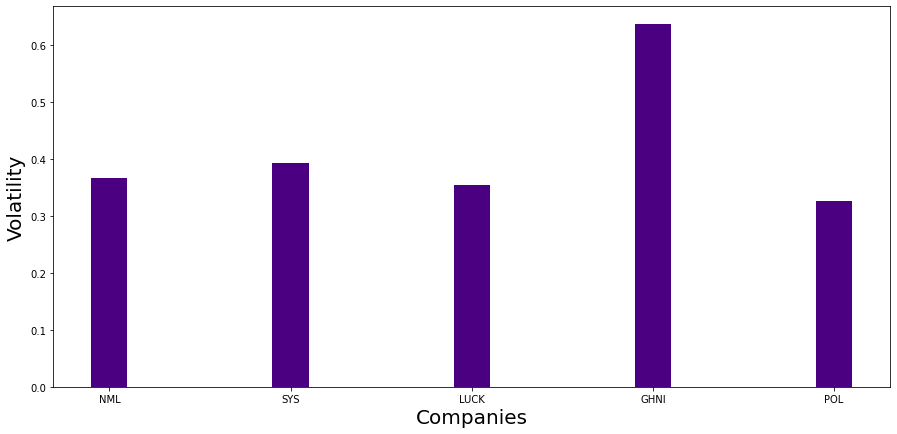

In [7]:
# Degree of variation of a trading price series over time.
std = volatility_calculations(df,250) #  Calculate volatility for each company
fig = plt.figure(figsize = (15, 7))
plt.xlabel("Companies",size=20)
plt.ylabel("Volatility",size=20)
columns_name = [x.split('(')[-1].replace(')','') for x in df.columns]
plt.bar(columns_name, std, color ='indigo',width = 0.2)

#################################

## Expected returns for each company ( Specific time period ) 

In [8]:
time_period_occurance = 'Y'
round(individual_exprected_returns(df,time_period_occurance)*100,2)

Nishat Mills (NML)             -9.24
Systems (SYS)                  81.01
Lucky Cement (LUCK)            16.46
Ghandhara Industries (GHNI)     5.14
Pakistan Oilfields (POL)       -8.88
dtype: float64

##############################

## Variance of Portfolio and Volatility (std) of Portfolio

In [9]:
weights = np.random.random(len(df.columns)) # Random Weights to each stock which adds upto 100% of investment
weights = weights/np.sum(weights)
time_period = 250
print("Total Variance of Portfolio: ",total_portfolio_variance(df,time_period,weights))
print("Volatlity of total portfolio: ",round(total_portfolio_volatility(df,time_period,weights),2))

Total Variance of Portfolio:  0.11
Volatlity of total portfolio:  0.33


#####################
## Portfolio Correlation Matrix

In [10]:
portfolio_correlation(df)

,Nishat Mills (NML),Systems (SYS),Lucky Cement (LUCK),Ghandhara Industries (GHNI),Pakistan Oilfields (POL)
Nishat Mills (NML),1.000000,0.209220,0.575365,0.394655,0.422052
Systems (SYS),0.209220,1.000000,0.158030,0.134533,0.130803
Lucky Cement (LUCK),0.575365,0.158030,1.000000,0.415969,0.337413
Ghandhara Industries (GHNI),0.394655,0.134533,0.415969,1.000000,0.266998
Pakistan Oilfields (POL),0.422052,0.130803,0.337413,0.266998,1.000000


######################
## Indiviusal Expected returns 

In [11]:
time_period_occurance = "Y"
print("Returns on Portfolio in one year: \n")
individual_exprected_returns(df,time_period_occurance)

Returns on Portfolio in one year: 



Nishat Mills (NML)            -0.092430
Systems (SYS)                  0.810061
Lucky Cement (LUCK)            0.164582
Ghandhara Industries (GHNI)    0.051350
Pakistan Oilfields (POL)      -0.088829
dtype: float64

#################################

## Total Portfolio Return

In [12]:
#Portfolio returns on the basis of individual companies returns
time_period_occurance = "Y" # Yealy
ind_expectedRetruns = individual_exprected_returns(df,time_period_occurance) # get indivisual returns
port_er = (weights*ind_expectedRetruns).sum() # Portfolio expected returns based on weights (Investment)
print("Total Portfolio Expected Return: ", round(port_er,2))

Total Portfolio Expected Return:  0.04



##################################
## Getting Optimized Portfolio

In [13]:
## Getting n Random portfolio from which we will plot efficient frontier ant take optimal portfolio
num_portfolios = 10000
portfolios = random_portfolios(df,time_period,time_period_occurance,num_portfolios)

<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

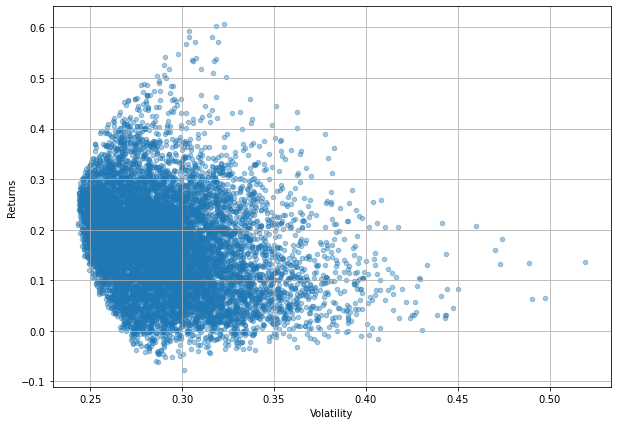

In [14]:
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=20, alpha=0.4, grid=True, figsize=[10,7])

## Portfolio with minimum Volatility

Minimum Volatility Portfolio


Returns                               0.232826
Volatility                            0.243730
Sharpe_ratio                          0.955262
Nishat Mills (NML) weight             0.098514
Systems (SYS) weight                  0.299124
Lucky Cement (LUCK) weight            0.194730
Ghandhara Industries (GHNI) weight    0.026993
Pakistan Oilfields (POL) weight       0.380639
Name: 7794, dtype: float64

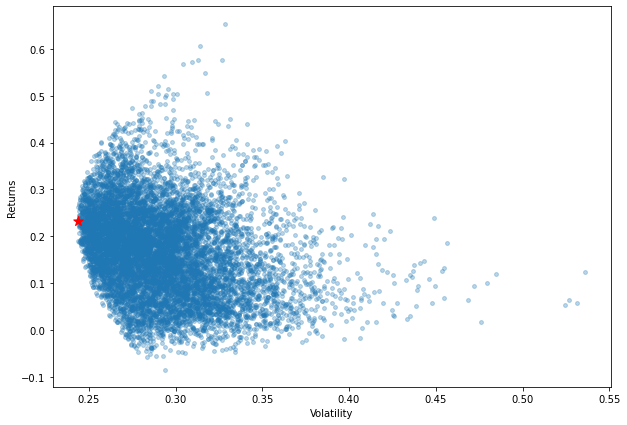

In [54]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]


plt.subplots(figsize=[10,7])
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=15, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=100)
print("Minimum Volatility Portfolio")
min_vol_port


########################

# Sharpe Ratio

## Optimal Risky Portfolio


In [55]:
# Finding the optimal portfolio
rf = 1 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns                               0.654169
Volatility                            0.328778
Sharpe_ratio                          1.989696
Nishat Mills (NML) weight             0.031827
Systems (SYS) weight                  0.780381
Lucky Cement (LUCK) weight            0.140776
Ghandhara Industries (GHNI) weight    0.042528
Pakistan Oilfields (POL) weight       0.004487
Name: 4102, dtype: float64

In [19]:
portfolios.iloc[(portfolios["Returns"]).idxmax()]

Returns                        0.607615
Volatility                     0.322982
Sharpe_ratio                   1.881264
Nishat Mills (NML)             0.093919
Systems (SYS)                  0.747185
Lucky Cement (LUCK)            0.056221
Ghandhara Industries (GHNI)    0.077743
Pakistan Oilfields (POL)       0.024932
Name: 7473, dtype: float64

# Efficient Frontier- Markowitz

In [15]:
max_return = round(portfolios['Returns'].to_list()[portfolios['Sharpe_ratio'].argmax()],2)
max_volatility = round(portfolios['Volatility'].to_list()[portfolios['Sharpe_ratio'].argmax()],2)
max_return,max_volatility,portfolios['Sharpe_ratio'].argmax()

(0.59, 0.3, 7784)

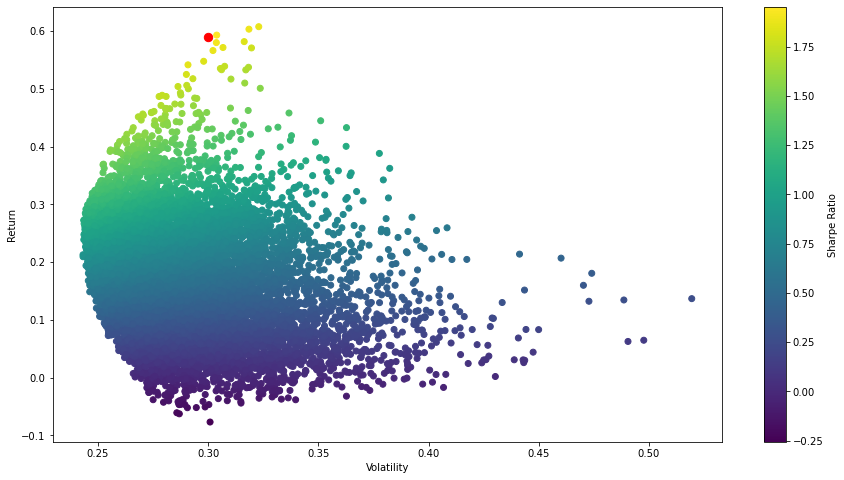

In [16]:
plt.figure(figsize=(15,8))
plt.scatter(portfolios['Volatility'], portfolios['Returns'], c=portfolios['Sharpe_ratio'], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_volatility, max_return,c='red', s=70) # red dot
plt.show()